# Logistic Regression

In [66]:
import pandas as pd
import numpy as np

In [67]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
train_labels = np.ravel(train_labels)

test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

## Preprocessing Pipeline

In [68]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline 


In [69]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

In [70]:
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [71]:
cat_features = [col for col in ['is_tarmac', 'length_cat', 'climb_cat'] if col not in columns_to_drop]
# Define the preprocessing for numeric and categorical features
numeric_features = [col for col in train_data.columns if col not in cat_features]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', 'passthrough', cat_features)
    ]
)

## Logistic Regression Model

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline

In [73]:
log_classifier = LogisticRegression(max_iter=2000, class_weight={0:1, 1:10}, random_state=42)

#pipeline
pipe = imbpipeline(steps=[('preprocessor', preprocessor),
                            ('sampler', SMOTE(random_state=42)),
                       ('classifier', log_classifier)])

parameters = {
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
    'classifier__penalty': ['l1', 'l2', None],
    'classifier__tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__class_weight': ['balanced', None]
}


scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': get_scorer("precision"),
    'sensitivity': get_scorer("recall"),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

In [74]:
# Perform randomized search cross-validation
random_search = RandomizedSearchCV(pipe, 
                                   param_distributions=parameters, 
                                   scoring=scoring,
                                   cv=5, # already stratified
                                   verbose=1, 
                                   n_jobs=-1, 
                                   refit='f1',
                                   n_iter=50)
random_search.fit(train_data, train_labels)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/effepielle/Developer/university/unipi/dm/dm_project24_group_0/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/effepielle/Developer/university/unipi/dm/dm_project24_group_0/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/effepielle/Developer/university/unipi/dm/dm_project24_group_0/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/effepielle/Developer/university/unipi/dm/dm_project24_group_0/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/effepielle/Developer/university/unipi/dm/dm_p

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['climb_total',
                                                                                'cyclist_age',
                                                                                'cyclist_level',
                                                                                'cyclist_experience',
                                                                                'avg_relative_position',
                                                                                'position_entropy',
                                                                                'top_20_entropy']),
                                                                              ('cat',
                                                                               'passthrough',
                                                                               [])])),
                                             ('sampler',
                                              SMOTE(random_state=42)),
                                             ('classifier',
                                              LogisticRegression(clas...
                            'f1': make_scorer(f1_score, response_method='predict', average=binary),
                            'precision': make_scorer(precision_score, response_method='predict', average=binary),
                            'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                            'sensitivity': make_scorer(recall_score, response_method='predict', average=binary),
                            'specificity': make_scorer(specificity_score, response_method='predict')},
                   verbose=1)

## Model Assessment

### Validation scores:

In [75]:
# extract the results of the randomized search and best model idx
cv_results =random_search.cv_results_
best_model = random_search.best_estimator_
best_index = random_search.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring.keys()}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring.keys()}

print("Validation results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.6960, Std: 0.0289
Specificity - Mean: 0.6758, Std: 0.0426
Accuracy - Mean: 0.6785, Std: 0.0342
Precision - Mean: 0.2493, Std: 0.0186
Roc_auc - Mean: 0.7458, Std: 0.0138
F1 - Mean: 0.3664, Std: 0.0187


Accuracy: 0.637
Recall: 0.757
Precision: 0.253
Sensitivity: 0.757
Specificity: 0.616
F1 Score: 0.379
ROC AUC Score: 0.687


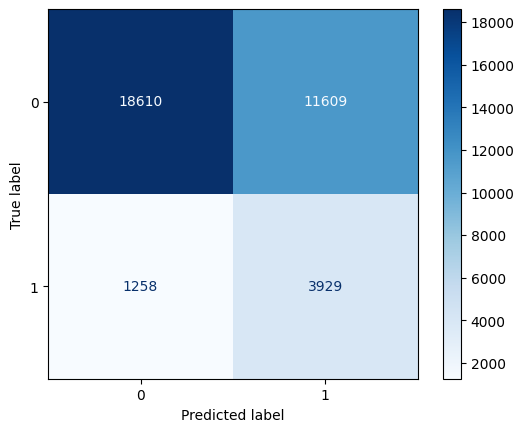

In [76]:
# Predict on the test data
test_predictions = random_search.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [77]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.62      0.74     30219
           1       0.25      0.76      0.38      5187

    accuracy                           0.64     35406
   macro avg       0.59      0.69      0.56     35406
weighted avg       0.84      0.64      0.69     35406



In [78]:
import joblib
import os

# Create the directory if it doesn't exist
os.makedirs('best_models', exist_ok=True)
# Save the best model
joblib.dump(best_model, 'best_models/nb.pkl')

['best_models/nb.pkl']

Double click to show a better view of the table.


UNDERSAMPLING
                  precision    recall  f1-score   support

           0       0.94      0.62      0.74     30219
           1       0.25      0.76      0.38      5187

    accuracy                           0.64     35406
   macro avg       0.59      0.69      0.56     35406
weighted avg       0.84      0.64      0.69     35406


OVERSAMPLING

precision    recall  f1-score   support

           0       0.94      0.62      0.75     30219
           1       0.25      0.75      0.38      5187

    accuracy                           0.64     35406
   macro avg       0.60      0.69      0.56     35406
weighted avg       0.84      0.64      0.69     35406